In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import random

%matplotlib inline

In [86]:
def make_dataset(data, y_cols, ix = np.arange(0, -10, -1), iy = [1, 2, 3, 4, 5]):
    
    '''Making two dataframes X and y. Each row of X is concatenation of rows of original data for 
       shifts defined by ix. Dataframe y has rows of original data taken with shift iy'''

    cols = data.columns
    data_ar = np.array(data)
    if len(y_cols) == 1:
        y_data_ar = np.array(data[y_cols[0]])
    else:
        y_data_ar = np.array(data[y_cols])
    N = len(data)
    X, y = [], []
    for i in range(-ix[-1], N - max(iy)):
        rows = np.concatenate([data_ar[i + shift] for shift in ix], axis = 0)
        y_row = ([y_data_ar[i + iy_s] for iy_s in iy])
        X.append(rows)
        y.append(y_row)
        
    new_cols = [c + ' %d steps before' % (-i) for i in ix for c in cols]
    X = pd.DataFrame(X, columns = new_cols)
    y = pd.DataFrame(y, columns = [ycol + str(iy_i) for iy_i in iy for ycol in y_cols])
    return X, y

In [9]:
stations = [name for name in os.listdir('./') if 'station' in name]

In [14]:
dfs = []
for name in stations:
    df = pd.read_csv(name,  sep = ';')
    dfs.append(df)

In [94]:
iy = [1, 2, 3, 4, 5]

In [42]:
data = dfs[0]
xcols = ['tmk', 'tnk', 'upm', 'vpm', 'txk']
y_cols = ['tmk']
for col in xcols:
    num_nans = data.isna()[col].value_counts()[1]
    print('For column %s number of NaNs is %d' % (col, num_nans))
    
data_clear = data[xcols].fillna(method = 'backfill')
X, ys = make_dataset(data_clear, y_cols = y_cols, iy= iy)

For column tmk number of NaNs is 646
For column tnk number of NaNs is 503
For column upm number of NaNs is 2971
For column vpm number of NaNs is 2970
For column txk number of NaNs is 502


In [96]:
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [102]:
clfs = []
for i in range(len(iy)):
    clf = GBR()
    clf.fit(X, ys['tmk%d' % (i + 1)])
    clfs.append(clf)

In [183]:
data = dfs[0]
xcols = ['tmk', 'tnk', 'upm', 'vpm', 'txk']
y_cols = ['tmk']
for col in xcols:
    num_nans = data.isna()[col].value_counts()
    if len(num_nans) == 1:
        num_nans = 0
    else:
        num_nans = num_nans[1]
    print('For column %s number of NaNs is %d' % (col, num_nans))
    
data_clear = data[xcols].fillna(method = 'backfill')
X, ys = make_dataset(data_clear, y_cols = y_cols, iy= iy)

For column tmk number of NaNs is 646
For column tnk number of NaNs is 503
For column upm number of NaNs is 2971
For column vpm number of NaNs is 2970
For column txk number of NaNs is 502


In [184]:
preds = [clf.predict(X) for clf in clfs]

In [185]:
from sklearn.metrics import mean_squared_error as mse

In [186]:
preds[0].shape

(13241,)

Accuracy for prediction 1 step ahead is 4.4938
Accuracy for prediction 2 step ahead is 8.7555
Accuracy for prediction 3 step ahead is 11.2312
Accuracy for prediction 4 step ahead is 12.7803
Accuracy for prediction 5 step ahead is 13.8079


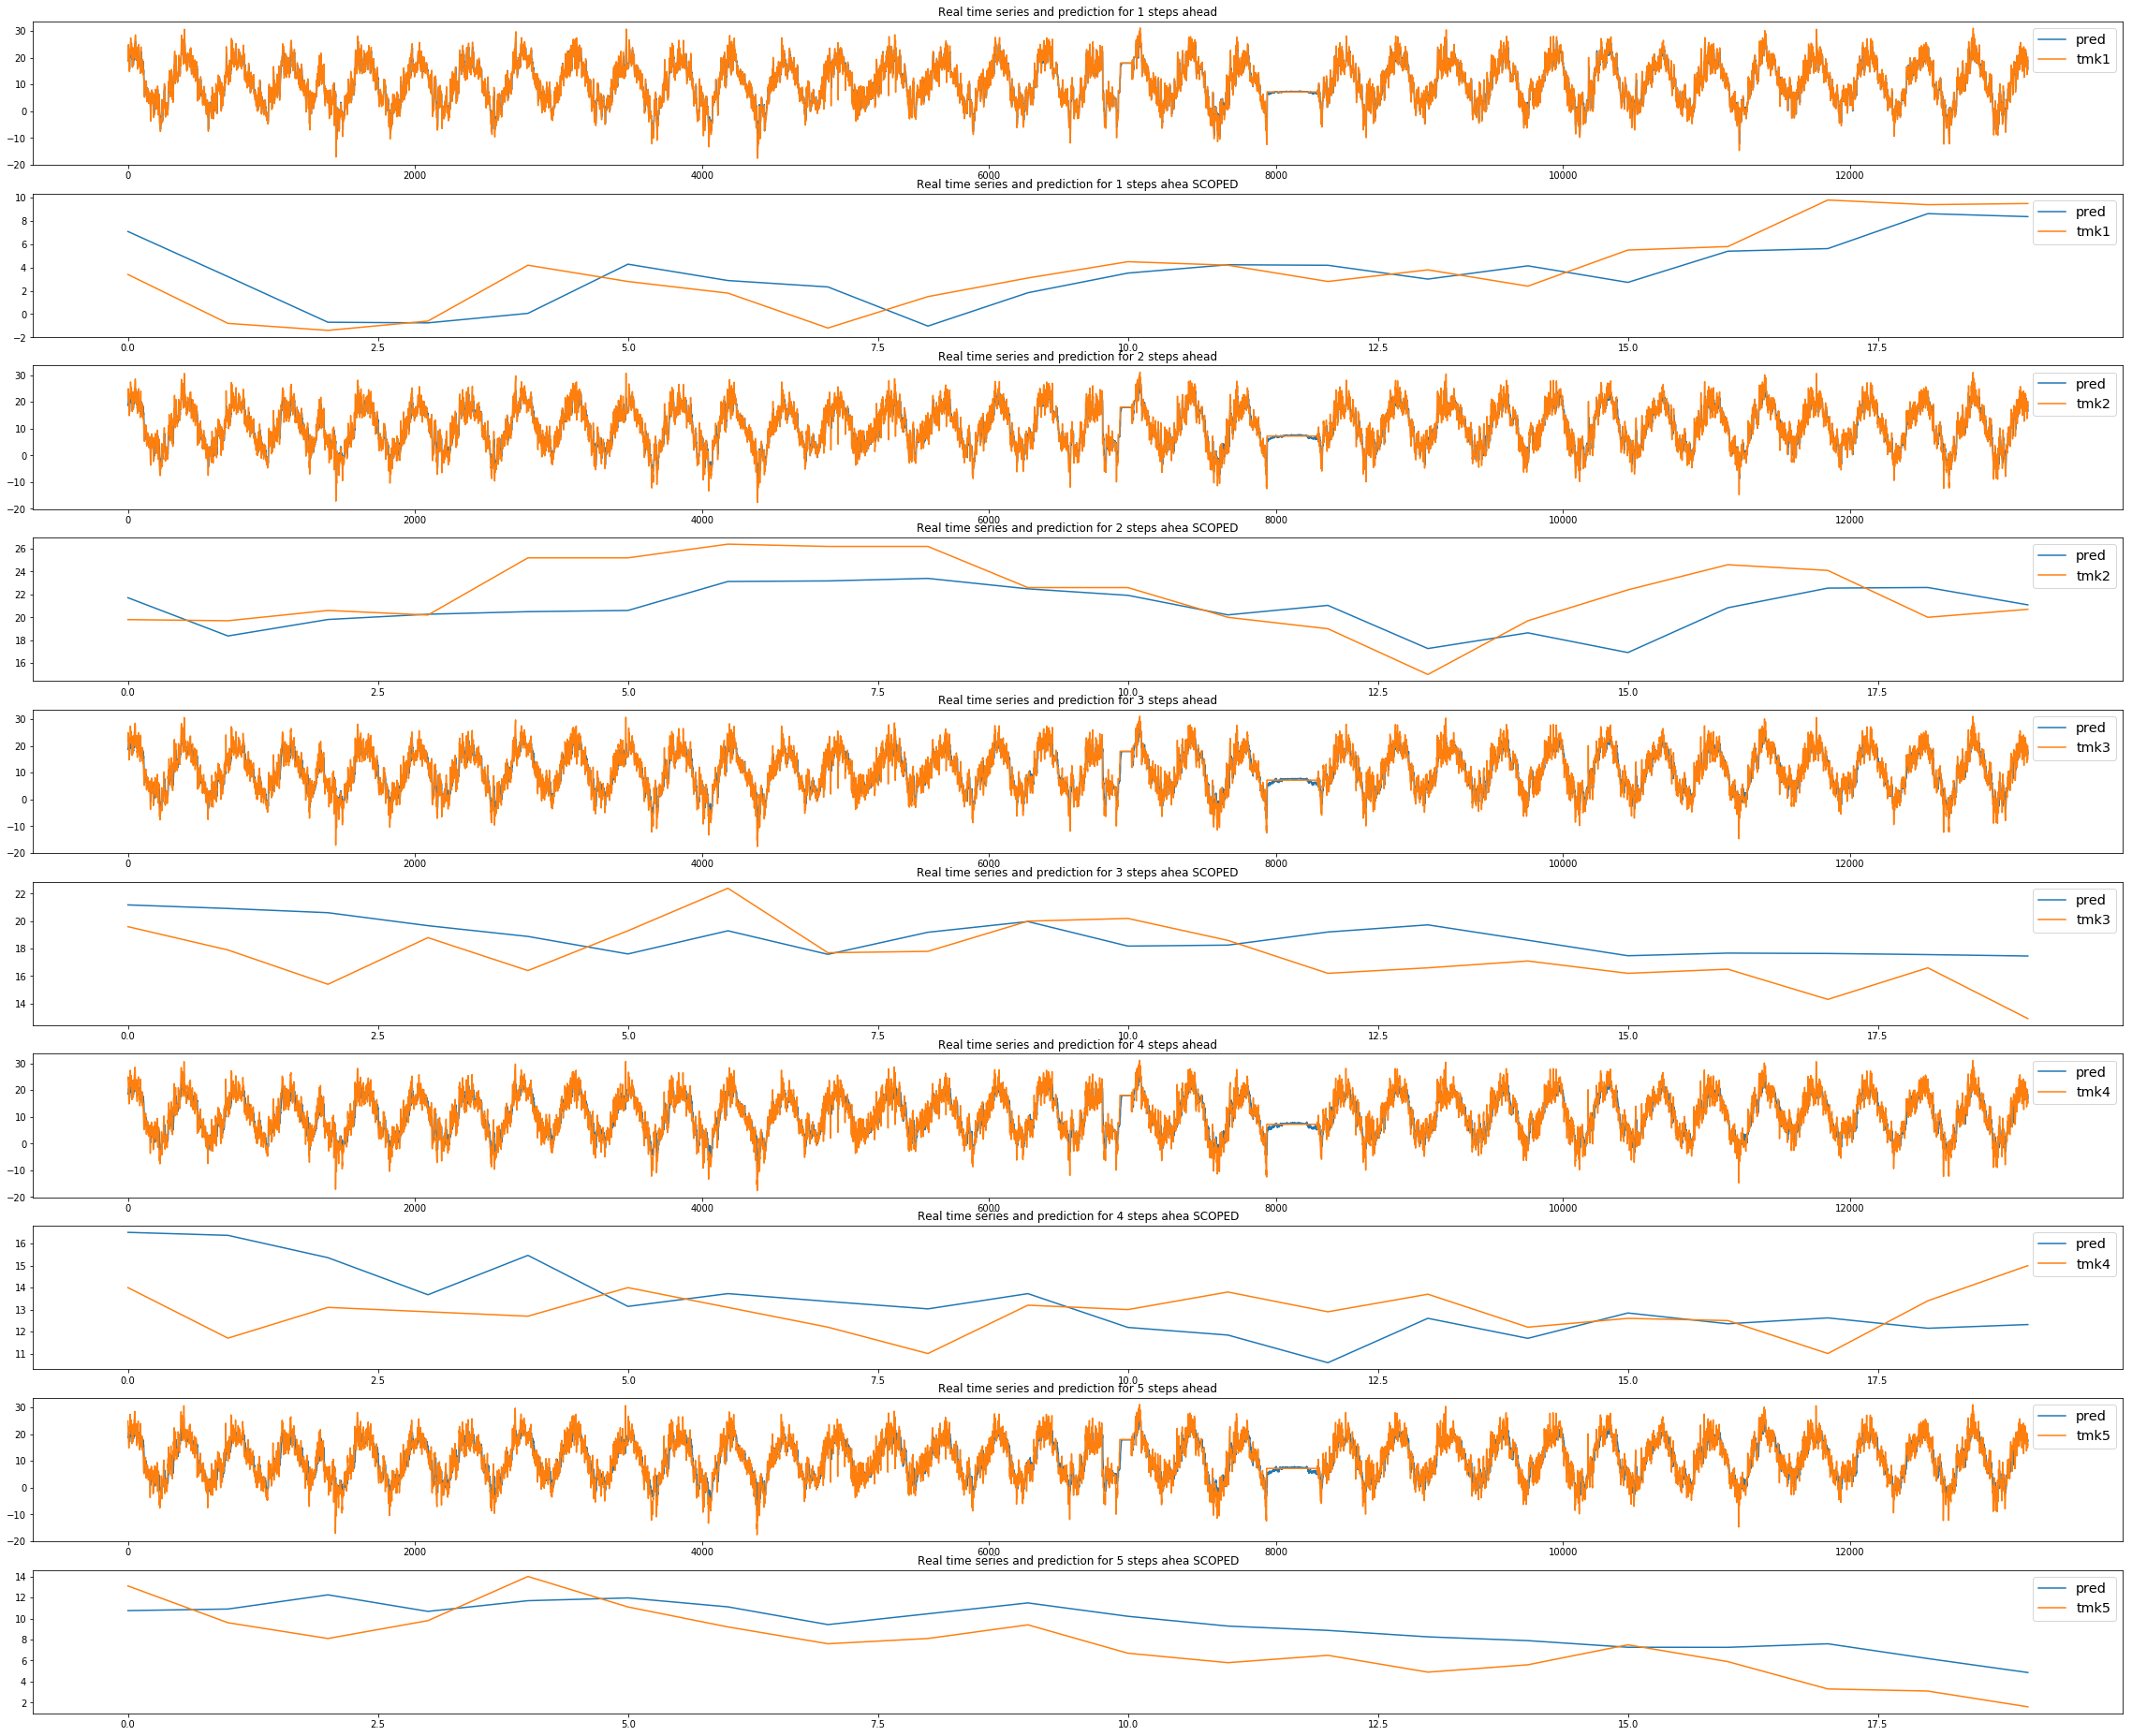

In [187]:
plt.figure(figsize = (40, 40))
len_scoped = 20
for i in range(len(iy)):
    plt.subplot(2 * len(iy) + 2, 1, 2 * i + 1)
    plt.title('Real time series and prediction for %d steps ahead' % (i + 1))
    res = mse(preds[i], ys['tmk%d' % (i + 1)])
    plt.plot(preds[i], label = 'pred')
    plt.plot(ys['tmk%d' % (i + 1)])
    _ = plt.legend(fontsize = 'x-large')
    
    plt.subplot(2 * len(iy) + 2, 1, 2 * i + 2)
    plt.title('Real time series and prediction for %d steps ahea SCOPED' % (i + 1))
    start = random.choice(range(0, preds[0].shape[0] - len_scoped))
    plt.plot(range(len_scoped), preds[i][start : start + len_scoped], label = 'pred')
    plt.plot(range(len_scoped), ys['tmk%d' % (i + 1)][start : start + len_scoped])
    _ = plt.legend(fontsize = 'x-large')
    print('Accuracy for prediction %d step ahead is %.4f' %(i + 1,res))

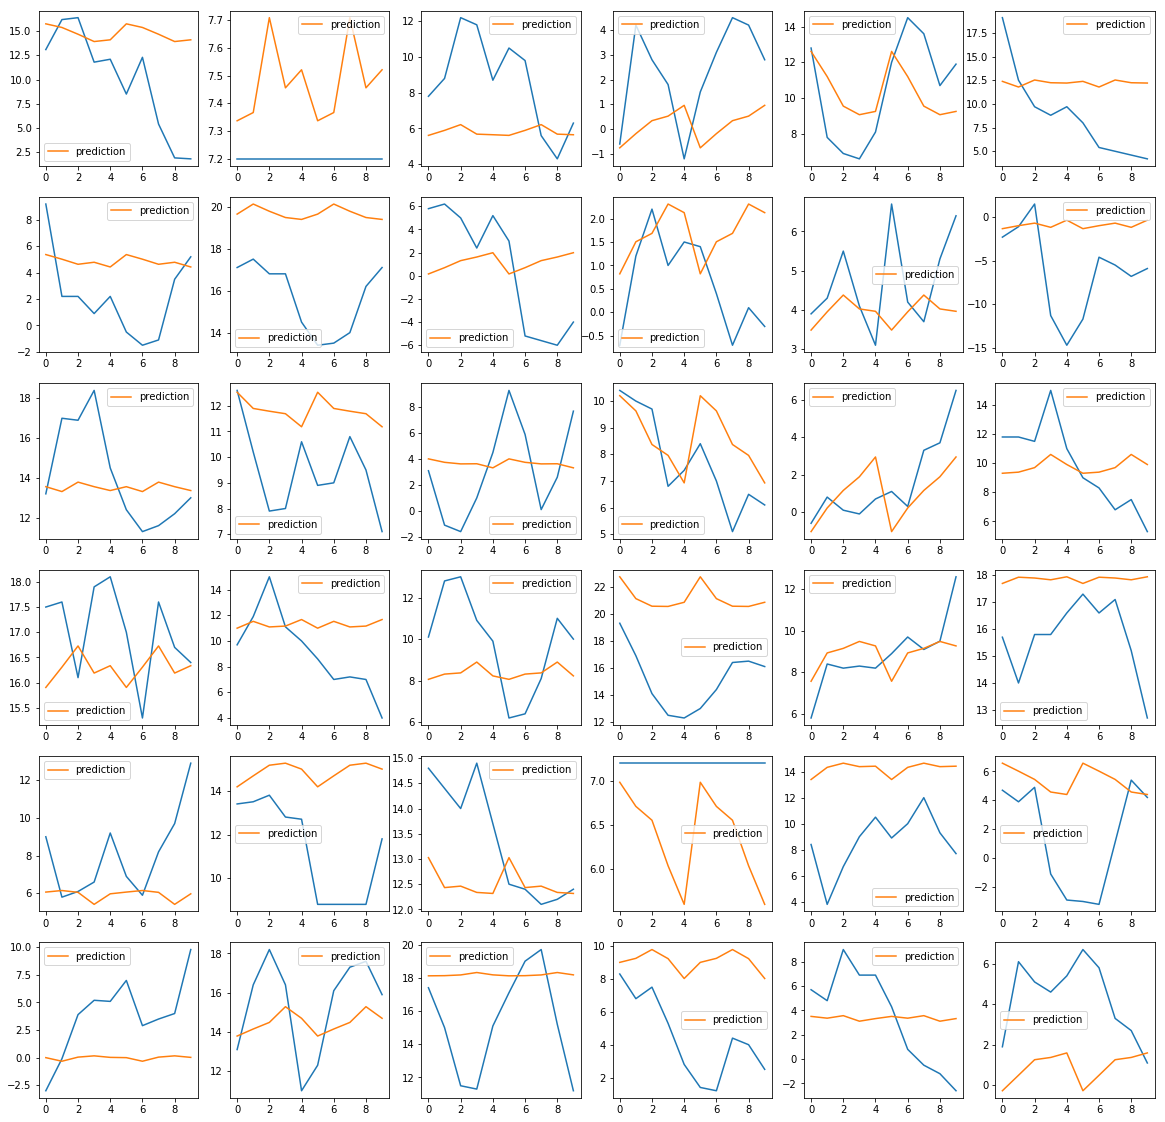

In [190]:
rand_segs = 6, 6
plt.figure(figsize =  (20, 20))
for i in range(rand_segs[0] * rand_segs[1]):
    start = random.choice(range(0, len(X) - 10))
    datarow1 = X[start : start + 1]
    datarow2 = X[start + 5 : start + 6]
    ans1 = ys[start : start + 1]
    ans1 = np.array(ans1)[0]
    ans2 = ys[start + 5 : start + 6]
    ans2 = np.array(ans2)[0]
    preds1 = [clf.predict(datarow1) for clf in clfs]
    preds2 = [clf.predict(datarow1) for clf in clfs]
    ans = np.concatenate([ans1, ans2], axis = 0)
    preds = np.array(preds1 + preds2).reshape(ans.shape)
    plt.subplot(rand_segs[0], rand_segs[1], i + 1)
    plt.plot(ans)
    plt.plot(preds, label = 'prediction')
    _ = plt.legend()